# PROYECTO 1. DEEP LEARNING
## Shelter Animal Outcomes
Sandra Marcela Meneses - Angélica María Gómez Buitrago - Juan Camilo Castillo Castro - Diego Fernando López Castillo 

Se cargan las librerías necesarias para el desarrollo del proyecto

In [146]:
#Librerías
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
%matplotlib inline

Se cargan las bases de datos de train y test

In [147]:
#Cargue de las bases de datos
import zipfile
with zipfile.ZipFile('../Proyecto/train.zip', 'r') as z:
    f = z.open('train.csv')
    data_train = pd.io.parsers.read_table(f, sep=',')
    
with zipfile.ZipFile('../Proyecto/test.zip', 'r') as z:
    f = z.open('test.csv')
    data_test = pd.io.parsers.read_table(f, sep=',')

Se visualizan las variables que se tienen en la base de train.

In [148]:
data_train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


## Identificación de Missing Values

Se identifican los missing values en cada una de las dos bases

In [149]:
data_train.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

In [150]:
data_test.isnull().sum()

ID                   0
Name              3225
DateTime             0
AnimalType           0
SexuponOutcome       0
AgeuponOutcome       6
Breed                0
Color                0
dtype: int64

Nos interesa conocer el tipo de objeto que hay tanto en los datos de train como de test:

In [151]:
data_train.dtypes

AnimalID          object
Name              object
DateTime          object
OutcomeType       object
OutcomeSubtype    object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtype: object

In [152]:
data_test.dtypes

ID                 int64
Name              object
DateTime          object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtype: object

Dado que la primera variable es un identificador (AnimalIID en train y ID en test) se descartará en el análisis por lo que se eliminará del data frame. Adicionalmente, en los datos de test no existe la variable "Outcome Subtype", y en los datos de train presenta una gran cantidad de NA por lo que también será eliminada del data frame. 

In [153]:
del data_train['AnimalID']
del data_train['OutcomeSubtype']
del data_test['ID']

# ANÁLISIS DE VARIABLES
Se analiza la variable de edad, que es la única numérica disponible. Sin embargo, requiere ajustes dado que está como
texto con varios patrones:

In [154]:
#Se cuentan los valores en la variable "AgeuponOutcome"
data_train["AgeuponOutcome"].value_counts()

1 year       3969
2 years      3742
2 months     3397
3 years      1823
1 month      1281
3 months     1277
4 years      1071
5 years       992
4 months      888
6 years       670
3 weeks       659
5 months      652
6 months      588
8 years       536
7 years       531
2 weeks       529
10 months     457
10 years      446
8 months      402
4 weeks       334
9 years       288
7 months      288
12 years      234
9 months      224
1 weeks       171
11 months     166
1 week        146
13 years      143
11 years      126
3 days        109
2 days         99
14 years       97
15 years       85
1 day          66
6 days         50
4 days         50
16 years       36
5 days         24
0 years        22
17 years       17
5 weeks        11
18 years       10
19 years        3
20 years        2
Name: AgeuponOutcome, dtype: int64

In [155]:
data_test["AgeuponOutcome"].value_counts()

1 year       1768
2 years      1641
2 months     1532
3 years       766
3 months      511
1 month       501
4 years       435
5 years       414
4 months      395
3 weeks       291
5 months      277
6 years       257
6 months      247
7 years       238
8 years       236
2 weeks       198
10 months     196
8 months      167
7 months      167
10 years      152
4 weeks       131
9 years       106
12 years       96
9 months       89
1 weeks        76
11 months      75
1 week         74
13 years       71
11 years       48
14 years       46
2 days         40
3 days         39
15 years       30
6 days         30
4 days         28
1 day          18
5 days         14
17 years       13
0 years        13
16 years        9
20 years        5
5 weeks         4
22 years        2
19 years        2
18 years        2
Name: AgeuponOutcome, dtype: int64

Se define la siguiente función para convertir la edad a meses, transformándola de una variable categórica a una numérica:

In [156]:
def conv_age(a):
    a = str(a)
    if a == 'nan': return 0
    age = int(a.split()[0])
    if a.find('year') > -1: return age*12 
    if a.find('month')> -1: return age
    if a.find('week')> -1: return age/4
    if a.find('day')> -1: return age/30
    else: return 0

data_train['Age_Months'] = data_train.AgeuponOutcome.apply(conv_age)
data_test['Age_Months'] = data_test.AgeuponOutcome.apply(conv_age)

## ANÁLISIS DE VARIABLES CATEGÓRICAS

Hemos identificado en el análisis exploratorio que existen numerosas variables categóricas que ameritan ya sea una creación de variables a partir de las variables originales, o una codificación diferente.

### 'SexuponOutcome'
Se crea la variable categórica "Sterile_Ind" que indica si la mascota está o no esterilizada, o si no se sabe, lo cual se realiza por medio de otra función, conociendo de antemano las categorías de la variable original que une sexo con estado:

In [157]:
#Conteo de animalitos con esterilización, castración, intactos o sin conocimiento
data_train["SexuponOutcome"].value_counts()

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
Name: SexuponOutcome, dtype: int64

In [158]:
data_test["SexuponOutcome"].value_counts()

Neutered Male    4235
Spayed Female    3813
Intact Female    1493
Intact Male      1460
Unknown           455
Name: SexuponOutcome, dtype: int64

In [159]:
#Creación de la variable "Sterile_Ind"
def sterile(m):
    m = str(m)
    if m.find('Neutered') >= 0: return 'Sterile' 
    if m.find('Spayed')>=0: return 'Sterile'
    if m.find('Intact')>= 0: return 'Intact'
    return m

data_train['Sterile_Ind'] = data_train.SexuponOutcome.apply(sterile)
data_test['Sterile_Ind'] = data_test.SexuponOutcome.apply(sterile)
data_train.head()

,Name,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Age_Months,Sterile_Ind
0,Hambone,2014-02-12 18:22:00,Return_to_owner,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,12.00,Sterile
1,Emily,2013-10-13 12:44:00,Euthanasia,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,12.00,Sterile
2,Pearce,2015-01-31 12:28:00,Adoption,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,24.00,Sterile
3,NaN,2014-07-11 19:09:00,Transfer,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0.75,Intact
4,NaN,2013-11-15 12:52:00,Transfer,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,24.00,Sterile


In [160]:
data_test.head()

,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Age_Months,Sterile_Ind
0,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White,10.0,Intact
1,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan,24.0,Sterile
2,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby,12.0,Sterile
3,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor,4.0,Intact
4,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White,24.0,Sterile


De la misma variable se crea aquella que contendrá el género de la mascota (macho, hembra o desconocido):

In [161]:
def animalsex(x):
    x = str(x)
    if x.find('Male') >= 0: return 'male'
    if x.find('Female') >= 0: return 'female'
    return 'unknown'

data_train['Sex'] = data_train.SexuponOutcome.apply(animalsex)
data_test['Sex'] = data_test.SexuponOutcome.apply(animalsex)
data_train.head()

,Name,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Age_Months,Sterile_Ind,Sex
0,Hambone,2014-02-12 18:22:00,Return_to_owner,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,12.00,Sterile,male
1,Emily,2013-10-13 12:44:00,Euthanasia,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,12.00,Sterile,female
2,Pearce,2015-01-31 12:28:00,Adoption,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,24.00,Sterile,male
3,NaN,2014-07-11 19:09:00,Transfer,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0.75,Intact,male
4,NaN,2013-11-15 12:52:00,Transfer,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,24.00,Sterile,male


In [162]:
data_test.head()

,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Age_Months,Sterile_Ind,Sex
0,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White,10.0,Intact,female
1,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan,24.0,Sterile,female
2,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby,12.0,Sterile,male
3,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor,4.0,Intact,male
4,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White,24.0,Sterile,male


## 'Name'

Para esta variable realizaremos una transformación para agrupar las mascotas entre aquellas que tienen nombre y aquellas que no. Esto con el fin de reducir el número de categorías de la base original. Esto se realizara por medio de otra función:

In [163]:
def named(x):
    x = str(x)
    if x == 'nan' : return 'Without_name'
    if x != 'nan' :return 'With_name'
    return 'unknown'

data_train['Named'] = data_train.Name.apply(named)
data_test['Named'] = data_test.Name.apply(named)
data_train.head()

,Name,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Age_Months,Sterile_Ind,Sex,Named
0,Hambone,2014-02-12 18:22:00,Return_to_owner,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,12.00,Sterile,male,With_name
1,Emily,2013-10-13 12:44:00,Euthanasia,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,12.00,Sterile,female,With_name
2,Pearce,2015-01-31 12:28:00,Adoption,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,24.00,Sterile,male,With_name
3,NaN,2014-07-11 19:09:00,Transfer,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0.75,Intact,male,Without_name
4,NaN,2013-11-15 12:52:00,Transfer,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,24.00,Sterile,male,Without_name


In [164]:
data_test.head()

,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Age_Months,Sterile_Ind,Sex,Named
0,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White,10.0,Intact,female,With_name
1,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan,24.0,Sterile,female,With_name
2,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby,12.0,Sterile,male,With_name
3,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor,4.0,Intact,male,With_name
4,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White,24.0,Sterile,male,With_name


## 'Color'

La idea es crear categorías que agrupen los datos disponibles de color, ya que de lo contrario trataríamos con muchas categorías. Este proceso consta de tres fases. Inicialmente, analizamos todas las categorías disponibles:

In [165]:
data_train['Color'].value_counts()

Black/White                    2824
Black                          2292
Brown Tabby                    1635
Brown Tabby/White               940
White                           931
Brown/White                     884
Orange Tabby                    841
Tan/White                       773
Tricolor                        752
Blue/White                      702
Black/Tan                       672
White/Black                     643
Brown                           639
Tan                             628
White/Brown                     569
Tortie                          530
Calico                          517
Orange Tabby/White              455
Brown Brindle/White             450
Blue                            450
Black/Brown                     436
Blue Tabby                      433
White/Tan                       389
Red                             337
Torbie                          335
Brown/Black                     333
Red/White                       331
Blue Tabby/White            

In [166]:
data_test['Color'].value_counts()

Black/White              1219
Black                     973
Brown Tabby               724
White                     402
Brown Tabby/White         393
Brown/White               373
Orange Tabby              346
Tan/White                 341
Tricolor                  315
Black/Tan                 314
Blue/White                302
White/Black               302
Tan                       282
Brown                     256
Tortie                    240
Blue                      224
Brown Brindle/White       211
White/Brown               202
Calico                    193
Black/Brown               188
Blue Tabby                183
Orange Tabby/White        174
White/Tan                 168
Brown/Black               160
Red/White                 140
Torbie                    139
Red                       133
Brown Brindle             115
Cream Tabby               111
Chocolate/White            97
                         ... 
Tricolor/Tan                1
Fawn/Brown                  1
Blue Tabby

Posteriormente, hacemos una primera categorización que consta de encontrar "/" en el texto, lo que implica que la mascota tiene más de un color y por ende se agrupará bao la categoría "Mixed". Igualmente el color "Tricolor" se categoriza igualmentge como Mixed.

In [167]:
def color(x):
    x = str(x)
    if x.find('/') >= 0: return 'Mixed'
    elif x.find('Tricolor') >= 0: return 'Mixed'
    return x

data_train['color'] = data_train.Color.apply(color)
data_test['color'] = data_test.Color.apply(color)
data_train.head()

,Name,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Age_Months,Sterile_Ind,Sex,Named,color
0,Hambone,2014-02-12 18:22:00,Return_to_owner,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,12.00,Sterile,male,With_name,Mixed
1,Emily,2013-10-13 12:44:00,Euthanasia,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,12.00,Sterile,female,With_name,Cream Tabby
2,Pearce,2015-01-31 12:28:00,Adoption,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,24.00,Sterile,male,With_name,Mixed
3,NaN,2014-07-11 19:09:00,Transfer,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0.75,Intact,male,Without_name,Blue Cream
4,NaN,2013-11-15 12:52:00,Transfer,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,24.00,Sterile,male,Without_name,Tan


In [168]:
data_test.head()

,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Age_Months,Sterile_Ind,Sex,Named,color
0,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White,10.0,Intact,female,With_name,Mixed
1,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan,24.0,Sterile,female,With_name,Mixed
2,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby,12.0,Sterile,male,With_name,Brown Tabby
3,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor,4.0,Intact,male,With_name,Mixed
4,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White,24.0,Sterile,male,With_name,White


In [169]:
data_train['color'].value_counts()

Mixed                14676
Black                 2292
Brown Tabby           1635
White                  931
Orange Tabby           841
Brown                  639
Tan                    628
Tortie                 530
Calico                 517
Blue                   450
Blue Tabby             433
Red                    337
Torbie                 335
Brown Brindle          232
Buff                   199
Sable                  198
Cream Tabby            198
Yellow                 185
Lynx Point             168
Cream                  151
Chocolate              137
Seal Point             136
Gray                    94
Flame Point             85
Blue Merle              77
Fawn                    73
Gold                    52
Black Smoke             46
Black Tabby             42
Lilac Point             39
Gray Tabby              35
Brown Merle             35
Tortie Point            32
Blue Point              29
Silver Tabby            28
Red Merle               26
Calico Point            25
A

In [170]:
data_test['color'].value_counts()

Mixed                6253
Black                 973
Brown Tabby           724
White                 402
Orange Tabby          346
Tan                   282
Brown                 256
Tortie                240
Blue                  224
Calico                193
Blue Tabby            183
Torbie                139
Red                   133
Brown Brindle         115
Cream Tabby           111
Yellow                 90
Lynx Point             87
Sable                  79
Cream                  71
Seal Point             68
Chocolate              68
Buff                   60
Blue Merle             41
Flame Point            35
Black Smoke            31
Fawn                   29
Gray                   24
Black Tabby            19
Gold                   17
Black Brindle          15
Lilac Point            14
Apricot                12
Brown Merle            11
Blue Point             11
Red Tick               11
Silver Tabby           10
Red Merle               8
Tortie Point            7
Chocolate Po

Finalmente, agrupamos los colores con palabras comunes para continuar la reducción de categorías y aquellos con una frecuencia menor a 100 en una nueva categoría denominada "Others".

In [171]:
def color2(x):
    x = str(x)
    if x.find('Blue') >= 0: return 'Blue'
    elif x.find('Black') >= 0: return 'Black'
    elif x.find('Brown') >= 0: return 'Brown'
    elif x.find('Chocolate') >= 0: return 'Chocolate'
    elif x.find('Red') >= 0: return 'Red'
    elif x.find('Silver') >= 0: return 'Silver'
    elif x.find('Orange') >= 0: return 'Orange'
    elif x.find('Gray') >= 0: return 'Gray'
    elif x.find('Yellow') >= 0: return 'Yellow'
    elif x.find('Cream') >= 0: return 'Cream'
    return x

data_train['color'] = data_train.color.apply(color2)
data_test['color'] = data_test.color.apply(color2)
data_train.head()

,Name,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Age_Months,Sterile_Ind,Sex,Named,color
0,Hambone,2014-02-12 18:22:00,Return_to_owner,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,12.00,Sterile,male,With_name,Mixed
1,Emily,2013-10-13 12:44:00,Euthanasia,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,12.00,Sterile,female,With_name,Cream
2,Pearce,2015-01-31 12:28:00,Adoption,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,24.00,Sterile,male,With_name,Mixed
3,NaN,2014-07-11 19:09:00,Transfer,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0.75,Intact,male,Without_name,Blue
4,NaN,2013-11-15 12:52:00,Transfer,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,24.00,Sterile,male,Without_name,Tan


In [172]:
#Creación variable "Others"
data_train.loc[data_train['color'].isin((data_train['color'].value_counts()[data_train['color'].value_counts() < 100]).index),
               'color'] = 'Other'
data_train['color'].value_counts()

Mixed         14676
Brown          2544
Black          2400
Blue           1023
White           931
Orange          857
Tan             628
Tortie          530
Calico          517
Red             380
Other           379
Cream           349
Torbie          335
Buff            199
Sable           198
Yellow          197
Lynx Point      168
Chocolate       153
Seal Point      136
Gray            129
Name: color, dtype: int64

In [173]:
data_train.head()

,Name,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Age_Months,Sterile_Ind,Sex,Named,color
0,Hambone,2014-02-12 18:22:00,Return_to_owner,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,12.00,Sterile,male,With_name,Mixed
1,Emily,2013-10-13 12:44:00,Euthanasia,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,12.00,Sterile,female,With_name,Cream
2,Pearce,2015-01-31 12:28:00,Adoption,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,24.00,Sterile,male,With_name,Mixed
3,NaN,2014-07-11 19:09:00,Transfer,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0.75,Intact,male,Without_name,Blue
4,NaN,2013-11-15 12:52:00,Transfer,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,24.00,Sterile,male,Without_name,Tan


In [174]:
data_test.loc[data_test['color'].isin((data_test['color'].value_counts()[data_test['color'].value_counts() < 100]).index),
               'color'] = 'Other'
data_test['color'].value_counts()

Mixed     6253
Brown     1106
Black     1038
Other      639
Blue       477
White      402
Orange     353
Tan        282
Tortie     240
Calico     193
Cream      182
Red        152
Torbie     139
Name: color, dtype: int64

In [175]:
data_test.head()

,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Age_Months,Sterile_Ind,Sex,Named,color
0,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White,10.0,Intact,female,With_name,Mixed
1,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan,24.0,Sterile,female,With_name,Mixed
2,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby,12.0,Sterile,male,With_name,Brown
3,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor,4.0,Intact,male,With_name,Mixed
4,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White,24.0,Sterile,male,With_name,White


## 'Breed'

Siguiendo un proceso similar al empleado con las variables previas, agruparemos las diferentes razas entre puras y mixtas, considerando que en caso contrario tendríamos una gran cantidad de categorías:

In [176]:
data_train['Breed'].value_counts()

Domestic Shorthair Mix                           8810
Pit Bull Mix                                     1906
Chihuahua Shorthair Mix                          1766
Labrador Retriever Mix                           1363
Domestic Medium Hair Mix                          839
German Shepherd Mix                               575
Domestic Longhair Mix                             520
Siamese Mix                                       389
Australian Cattle Dog Mix                         367
Dachshund Mix                                     318
Boxer Mix                                         245
Miniature Poodle Mix                              233
Border Collie Mix                                 229
Australian Shepherd Mix                           163
Rat Terrier Mix                                   157
Catahoula Mix                                     157
Jack Russell Terrier Mix                          146
Yorkshire Terrier Mix                             143
Domestic Shorthair          

In [177]:
data_test['Breed'].value_counts()

Domestic Shorthair Mix                            3777
Pit Bull Mix                                       870
Chihuahua Shorthair Mix                            732
Labrador Retriever Mix                             586
Domestic Medium Hair Mix                           378
German Shepherd Mix                                255
Domestic Longhair Mix                              233
Siamese Mix                                        173
Australian Cattle Dog Mix                          146
Dachshund Mix                                      119
Miniature Poodle Mix                               103
Border Collie Mix                                   95
Australian Shepherd Mix                             93
Boxer Mix                                           85
Yorkshire Terrier Mix                               70
Rat Terrier Mix                                     69
Miniature Schnauzer Mix                             67
Catahoula Mix                                       59
Jack Russe

Nuevamente acudimos a una función para crear dichas categorías, identificado aquellas razas que contienen la palabra "Mix" de las que no:

In [178]:
def breed(x):
    x = str(x)
    if x.find('Mix') >= 0: return 'Mixed'
    return 'Pure'

data_train['breed'] = data_train.Breed.apply(breed)
data_test['breed'] = data_test.Breed.apply(breed)
data_train.head()

,Name,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Age_Months,Sterile_Ind,Sex,Named,color,breed
0,Hambone,2014-02-12 18:22:00,Return_to_owner,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,12.00,Sterile,male,With_name,Mixed,Mixed
1,Emily,2013-10-13 12:44:00,Euthanasia,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,12.00,Sterile,female,With_name,Cream,Mixed
2,Pearce,2015-01-31 12:28:00,Adoption,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,24.00,Sterile,male,With_name,Mixed,Mixed
3,NaN,2014-07-11 19:09:00,Transfer,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0.75,Intact,male,Without_name,Blue,Mixed
4,NaN,2013-11-15 12:52:00,Transfer,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,24.00,Sterile,male,Without_name,Tan,Pure


In [179]:
data_test.head()

,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Age_Months,Sterile_Ind,Sex,Named,color,breed
0,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White,10.0,Intact,female,With_name,Mixed,Mixed
1,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan,24.0,Sterile,female,With_name,Mixed,Pure
2,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby,12.0,Sterile,male,With_name,Brown,Mixed
3,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor,4.0,Intact,male,With_name,Mixed,Mixed
4,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White,24.0,Sterile,male,With_name,White,Mixed


# ANÁLISIS EXPLORATORIO

A continuación, por medio de diferentes gráficas analizaremos las relaciones entre las diferentes variables. Se observa que el 40.3% de las mascotas que llegan al refugio han sido adoptadas, el 35.3% transferidas, el 18% han regresado con sus dueños, el 5.8% han sido sacrificados y el 0.7% han fallecido.

In [180]:
data_train["OutcomeType"].unique()
pd.value_counts(data_train['OutcomeType'])

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

Se grafica cada uno de los diferentes tipos de Outcome o salidas que pueden tener los animalitos

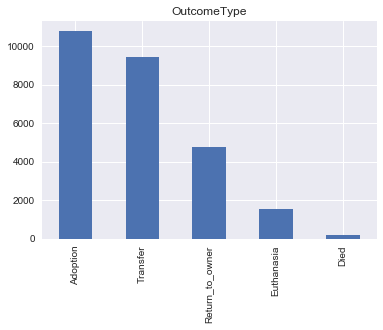

In [181]:
plot=data_train['OutcomeType'].value_counts().plot(kind='bar', title='OutcomeType')

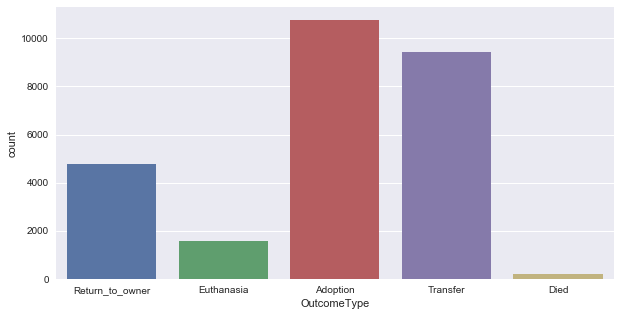

In [182]:
plt.figure(figsize=(10,5))
sns.countplot(x="OutcomeType",data=data_train)

La proporción entre perros y gatos son:

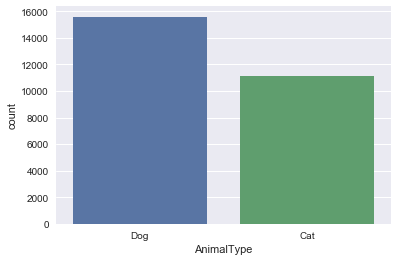

In [183]:
sns.countplot(data_train.AnimalType)

Las posibles salidas de acuerdo con la base de train, que podrían tener los animalitos de acuerdo con si son perros o gatos son:

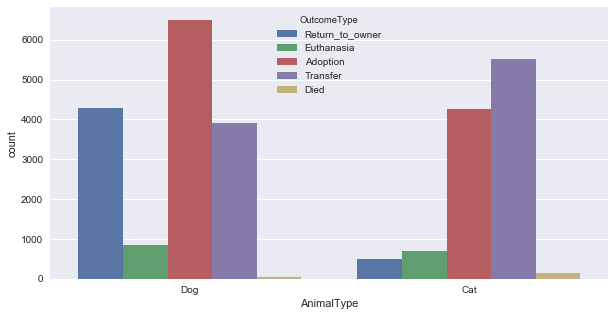

In [184]:
plt.figure(figsize=(10,5))
sns.countplot(x="AnimalType",hue="OutcomeType",data=data_train)

De acuerdo con esto, es más probable que si el animalito llega a un refugio porque se ha perdido retorne con su dueño si es perro. Por otro lado, las personas prefieren adoptar perros en lugar de gatos.

Se visualiza a continuación la proporción de perros y gatos de acuerdo con su fertilidad

In [185]:
pd.value_counts(data_train['SexuponOutcome'])

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
Name: SexuponOutcome, dtype: int64

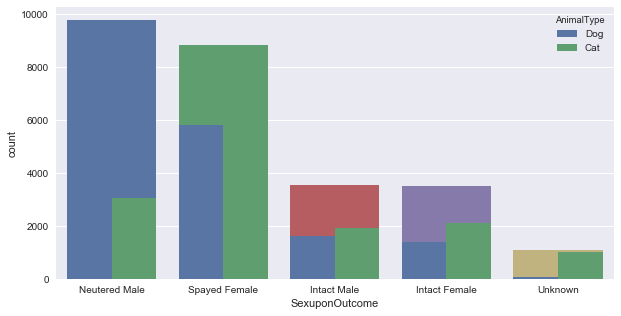

In [186]:
plt.figure(figsize=(10,5))
sns.countplot(data_train.SexuponOutcome)
sns.countplot(x="SexuponOutcome",hue="AnimalType",data=data_train)

De los machos castrados la mayoría son perros, sin embargo de las hembras esterilizadas la mayoría son gatas. Es mayor la proporción de animalitos castrados, sin embargo es necesario que ese valor sea mayor en los perritos que son hembras.

Hay una mayor proporción de machos que de hembras entre los animalitos que llegan a refugios. Hay una pequeña proporción de animalitos a los que no se les conoce o registra el sexo.

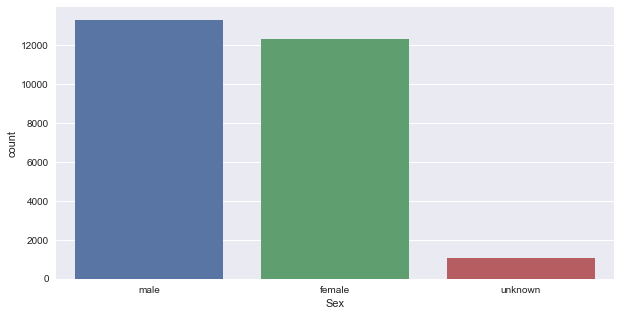

In [187]:
plt.figure(figsize=(10,5))
sns.countplot(x="Sex",data=data_train)

Se visualiza la proporción entre machos y hembras dependiendo de si son perros o gatos.

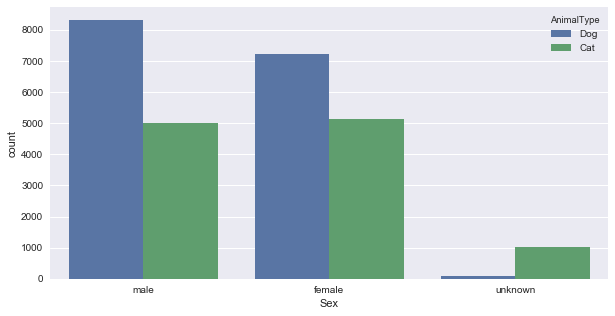

In [188]:
plt.figure(figsize=(10,5))
sns.countplot(x="Sex",hue="AnimalType",data=data_train)

Parece que los machos son igualmente adoptados que las hembras, sin embargo, es más probable que un macho regrese nuevamente con su dueño si ha llegado al refugio.

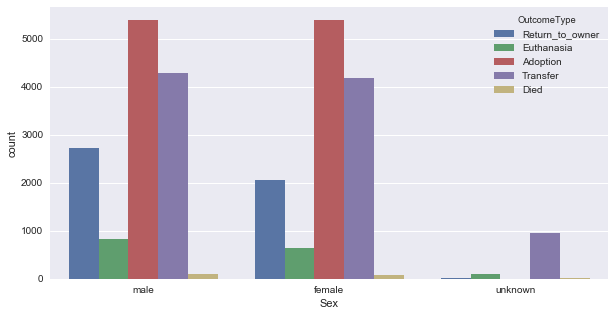

In [189]:
plt.figure(figsize=(10,5))
sns.countplot(x="Sex",hue="OutcomeType",data=data_train)

La mayoría de los animalitos tienen su pelaje con más de un color (Mixed). Son mas frecuentes los animalitos de pelo negro y café vs otros colores

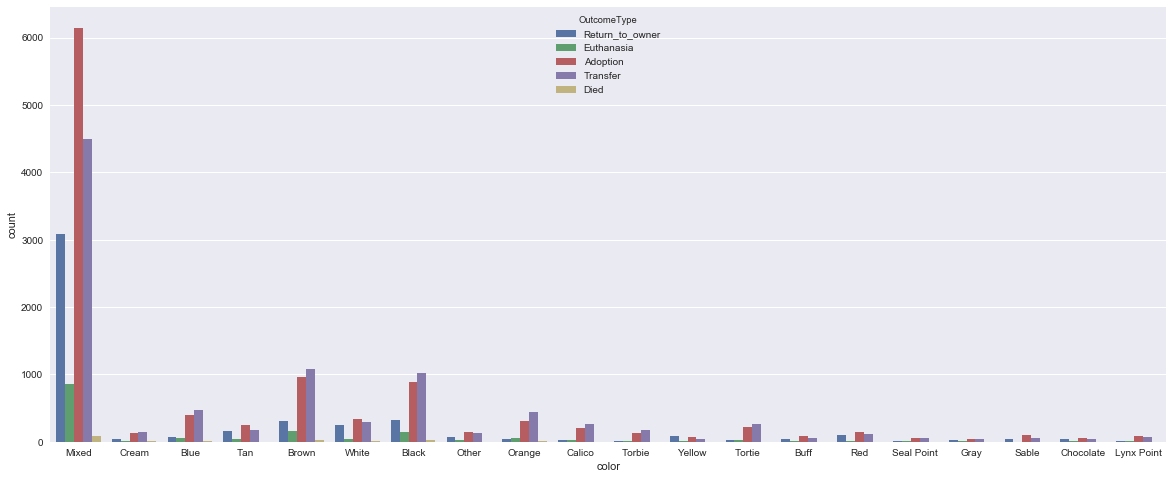

In [190]:
plt.figure(figsize=(20,8))
sns.countplot(x="color",hue="OutcomeType",data=data_train)

Hay mas hembritas con pelaje de color café que negro. Hay una gran proporción de animalitos machos con pelajede varios colores.

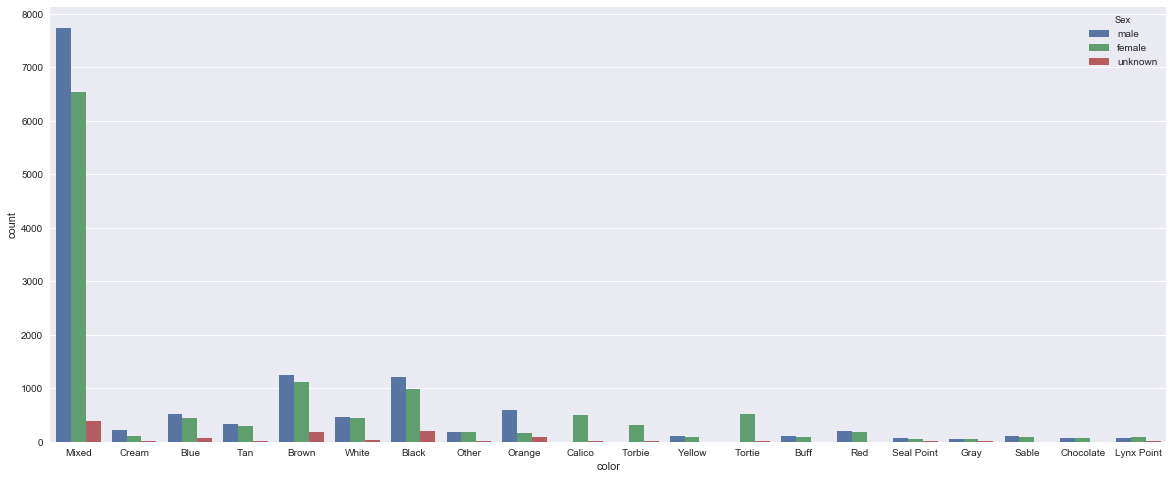

In [191]:
plt.figure(figsize=(20,8))
sns.countplot(x="color",hue="Sex",data=data_train)

Alrededor de 5000 perritos son de raza pura. La mayoría son criollos o mixtos.

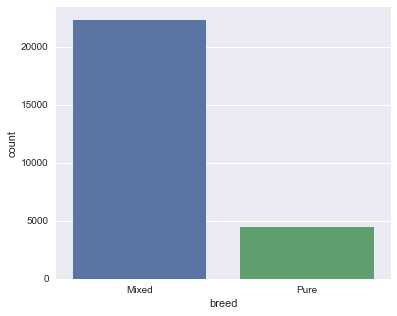

In [192]:
plt.figure(figsize=(6,5))
sns.countplot(x="breed",data=data_train)

Se visualiza que los animalitos que son de raza pura son menos sacrificados y mueren en menor cantidades que los que son criollos. Adicionalmente, los animalitos criollos tienen menos probabilidad de regresar con sus dueños que los de raza pura.

Con esto se podría pensar que se prefieren en general los animalitos de raza pura aunque en cantidades son muchos menos que los criollos

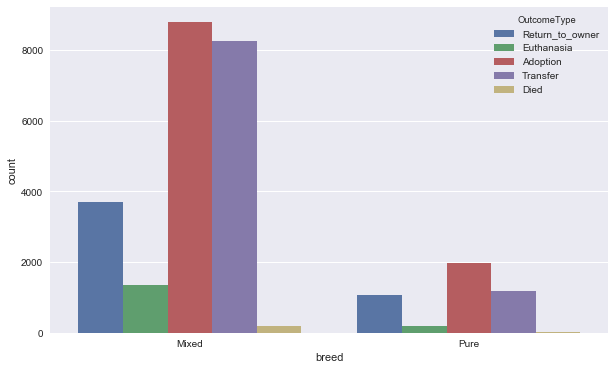

In [193]:
plt.figure(figsize=(10,6))
sns.countplot(x="breed",hue="OutcomeType",data=data_train)

Los animalitos más jóvenes son los que mas son adoptados y transferidos a otros refugios o dueños. 

Entre los animalitos mayores o viejitos se encuentran algunos que sacrifican. 

Si los animalitos se pierden, su dueño desea que el animalito retorne con el a su hogar con mayor frecuencia en los casos donde el animalito es joven.

Los animalitos muy jóvenes son los que menos probabilidad de vivir tienen y mueren con mayor frecuencia.

Se identifican algunos valores outliers en todos los estados.

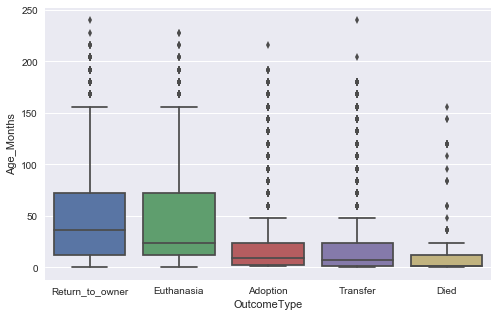

In [194]:
sns.set()
plt.figure(figsize=(8,5))
sns.boxplot(x="OutcomeType", y="Age_Months", data=data_train)
plt.show()

El sexo del animalito parece no incidir o impactar en la edad para que se presente alguna de las posibles salidas.

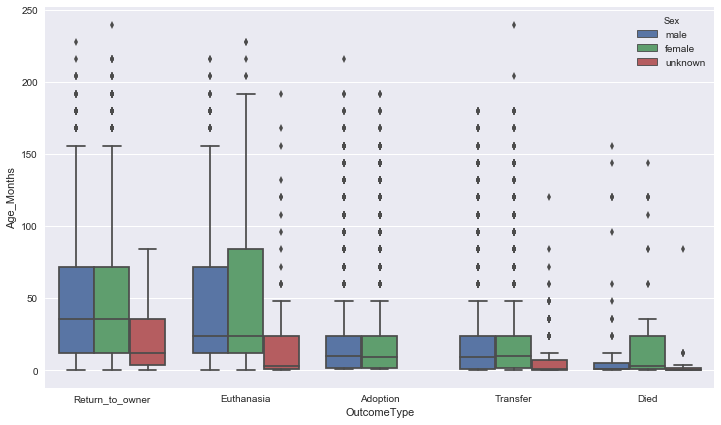

In [195]:
sns.set()
plt.figure(figsize=(12,7))
sns.boxplot(x="OutcomeType", y="Age_Months", hue="Sex", data=data_train)
plt.show()

Se ordena la variable "DataTime" y se grafica para identificar estacionariedad y estacionalidad o alguna tendencia

Int64Index([ 5000,  2404, 21130,  8965,  4092, 13518, 19815, 23646, 16692,
            20553,
            ...
             5113, 20022,  2498, 19094, 12984, 24638, 26551,  1511, 17818,
            16217],
           dtype='int64', length=26729)

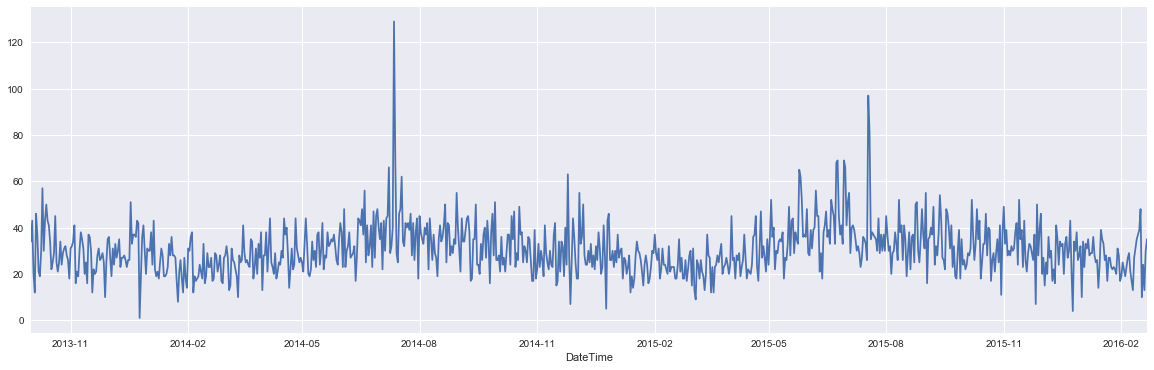

In [196]:
# Ordenar por fecha la base
data_train = data_train.sort_values(['DateTime'])
data_train.tail()
data_train["DateTime"] = pd.to_datetime(data_train["DateTime"]).dt.date
plt.figure(figsize=(20,6))
data_train["OutcomeType"].groupby(data_train["DateTime"]).count().plot(kind="line")
data_train["DateTime"].index

La variable no es estacionaria, parece existir alguna tendencia al incremento de salidas hacia los meses de mayo a agosto y una posterior disminución hacia fin de año.

Se separa el mes y año de las variable "DataTime"

In [197]:
time_train = pd.to_datetime(data_train["DateTime"])
time_test  = pd.to_datetime(data_test["DateTime"])

data_train["Year"] = time_train.dt.year
data_test["Year"] = time_test.dt.year

data_train["Month"] = time_train.dt.month
data_test["Month"] = time_test.dt.month

In [198]:
data_train.head()

,Name,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Age_Months,Sterile_Ind,Sex,Named,color,breed,Year,Month
5000,Dudley,2013-10-01,Adoption,Dog,Neutered Male,2 months,Labrador Retriever Mix,Black,2.00,Sterile,male,With_name,Black,Mixed,2013,10
2404,NaN,2013-10-01,Transfer,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,0.25,Unknown,unknown,Without_name,Mixed,Mixed,2013,10
21130,NaN,2013-10-01,Transfer,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,0.25,Unknown,unknown,Without_name,Mixed,Mixed,2013,10
8965,Moby,2013-10-01,Return_to_owner,Dog,Neutered Male,4 years,Bulldog Mix,White,48.00,Sterile,male,With_name,White,Mixed,2013,10
4092,NaN,2013-10-01,Transfer,Dog,Neutered Male,3 years,Toy Poodle Mix,White,36.00,Sterile,male,Without_name,White,Mixed,2013,10


Finalmente, se valida que las variables que van a ser utilizadas tengan valores NA.

In [199]:
data_train.isnull().sum()

Name              7691
DateTime             0
OutcomeType          0
AnimalType           0
SexuponOutcome       1
AgeuponOutcome      18
Breed                0
Color                0
Age_Months           0
Sterile_Ind          0
Sex                  0
Named                0
color                0
breed                0
Year                 0
Month                0
dtype: int64

## APLICACIÓN DE MODELOS DE CLASIFICACIÓN


Se eliminan las siguientes variables:

In [200]:
del data_train['Name']
del data_train['DateTime']
del data_train['SexuponOutcome']
del data_train['AgeuponOutcome']
del data_train['Breed']
del data_train['Color']

In [201]:
data_train

,OutcomeType,AnimalType,Age_Months,Sterile_Ind,Sex,Named,color,breed,Year,Month
5000,Adoption,Dog,2.00,Sterile,male,With_name,Black,Mixed,2013,10
2404,Transfer,Cat,0.25,Unknown,unknown,Without_name,Mixed,Mixed,2013,10
21130,Transfer,Cat,0.25,Unknown,unknown,Without_name,Mixed,Mixed,2013,10
8965,Return_to_owner,Dog,48.00,Sterile,male,With_name,White,Mixed,2013,10
4092,Transfer,Dog,36.00,Sterile,male,Without_name,White,Mixed,2013,10
13518,Transfer,Dog,24.00,Sterile,female,Without_name,Mixed,Mixed,2013,10
19815,Return_to_owner,Dog,108.00,Sterile,female,With_name,Black,Mixed,2013,10
23646,Adoption,Cat,5.00,Sterile,male,With_name,Black,Mixed,2013,10
16692,Euthanasia,Dog,12.00,Sterile,male,With_name,Mixed,Mixed,2013,10
20553,Return_to_owner,Dog,36.00,Sterile,male,With_name,Mixed,Mixed,2013,10


In [202]:
del data_test['Name']
del data_test['DateTime']
del data_test['SexuponOutcome']
del data_test['AgeuponOutcome']
del data_test['Breed']
del data_test['Color']
data_test

,AnimalType,Age_Months,Sterile_Ind,Sex,Named,color,breed,Year,Month
0,Dog,10.00,Intact,female,With_name,Mixed,Mixed,2015,10
1,Dog,24.00,Sterile,female,With_name,Mixed,Pure,2014,7
2,Cat,12.00,Sterile,male,With_name,Brown,Mixed,2016,1
3,Dog,4.00,Intact,male,With_name,Mixed,Mixed,2013,12
4,Dog,24.00,Sterile,male,With_name,White,Mixed,2015,9
5,Dog,36.00,Sterile,male,With_name,Mixed,Mixed,2015,6
6,Cat,156.00,Sterile,male,With_name,Mixed,Mixed,2014,3
7,Cat,6.00,Sterile,female,With_name,Brown,Mixed,2014,6
8,Dog,3.00,Sterile,female,With_name,Mixed,Pure,2014,11
9,Dog,12.00,Sterile,female,With_name,Mixed,Mixed,2014,4


Se transforman a categóricas las siguientes variables:

In [203]:
data_train['OutcomeType'] = pd.factorize(data_train.OutcomeType)[0]
data_train['AnimalType'] = pd.factorize(data_train.AnimalType)[0]
data_train['Sterile_Ind'] = pd.factorize(data_train.Sterile_Ind)[0]
data_train['Sex'] = pd.factorize(data_train.Sex)[0]
data_train['Named'] = pd.factorize(data_train.Named)[0]
data_train['color'] = pd.factorize(data_train.color)[0]
data_train['breed'] = pd.factorize(data_train.breed)[0]
data_train['Year'] = pd.factorize(data_train.Year)[0]
data_train['Month'] = pd.factorize(data_train.Month)[0]

data_train.head()

,OutcomeType,AnimalType,Age_Months,Sterile_Ind,Sex,Named,color,breed,Year,Month
5000,0,0,2.00,0,0,0,0,0,0,0
2404,1,1,0.25,1,1,1,1,0,0,0
21130,1,1,0.25,1,1,1,1,0,0,0
8965,2,0,48.00,0,0,0,2,0,0,0
4092,1,0,36.00,0,0,1,2,0,0,0


Se transforman a categóricas las siguientes variables:

## PARTICIÓN DE LOS DATOS EN TRAIN Y TEST

Para poder realizar la validación de los modelos se particiona la muestra de train en: una nueva muestra de train y test(de validación). 
Esto dado que en la muestra de test no tenemos la variable respuesta para probar el desempeño de los modelos.

In [204]:
#definición de X y Y
feature_cols = ['AnimalType','Age_Months','Sterile_Ind','Sex','Named','color','breed','Year','Month']
X = data_train[feature_cols]
y= data_train.OutcomeType

#Partición de una muestra de validación del train para poder probar los modelos
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)

(26729, 9)
(26729,)
(6683, 9)
(6683,)


Las clases quedan clasificadas así:
0 - Adopción
1 - Transfer
2 - Return_to_owner
3 - Euthanasia
4 - Died

In [205]:
y_test.value_counts()

0    2750
1    2305
2    1197
3     387
4      44
Name: OutcomeType, dtype: int64

## BALANCEO DE LAS CLASES

Procedemos a idenfiticar el posible desbalanceo de clases

# NOTA: Se debe instalar desde anaconda prompt pip install imblearn

In [206]:
y_train.value_counts()

0    8019
1    7117
2    3589
3    1168
4     153
Name: OutcomeType, dtype: int64

Se evidencia que existe un deslbalanceo de clases especialmente notorio para la clase 4, por lo cual decidimos optar por realizar Oversampling

In [207]:
from imblearn.over_sampling import RandomOverSampler

In [208]:
ros = RandomOverSampler(random_state=0)
X_train_o, y_train_o = ros.fit_sample(X_train, y_train)

Ahora los datos balanceados son X_train_o , y_train_o

In [209]:
print('New Rows Class 0 ',(y_train_o==0).sum())
print('New Rows Class 1 ',(y_train_o==1).sum())
print('New Rows Class 2 ',(y_train_o==2).sum())
print('New Rows Class 3 ',(y_train_o==3).sum())
print('New Rows Class 4 ',(y_train_o==4).sum())

New Rows Class 0  8019
New Rows Class 1  8019
New Rows Class 2  8019
New Rows Class 3  8019
New Rows Class 4  8019


## 1.RANDOM FOREST

Calibraremos el modelo encontrando el número de árboles (n-estimators) y tomando el parámetro m como la raíz del total de variables predictoras. Tenemos nueve, por lo que usaremos m = 3.


## Random Forest con datos sin balancear

### Tuning n_estimators

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
r_forest = RandomForestClassifier()
r_forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [69]:
from sklearn.metrics import accuracy_score

# list of values to try for n_estimators
estimator_range = range(10, 100, 10)

#list to store the accuracy for each value of n_estimators
acc_scores = []

for estimator in estimator_range:
    rfreg = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1, max_features=3)
    rfreg.fit(X_train, y_train)
    acc_scores.append(accuracy_score(y_test, rfreg.predict(X_test)))


Los valores de accuracy obtenidos son

In [70]:
acc_scores

[0.59718689211431997,
 0.59658835852162206,
 0.59988029328146042,
 0.599730659883286,
 0.60002992667963484,
 0.6021247942540775,
 0.60466856202304353,
 0.60347149483764773,
 0.60182552745772855]

Text(0,0.5,'Accuracy (bigger is better)')

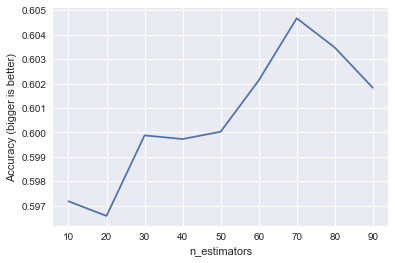

In [71]:
# plot n_estimators (x-axis) versus accuracy (y-axis)
plt.plot(estimator_range, acc_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy (bigger is better)')

El número de árboles que maximiza el accuracy es 70

In [72]:
r_forest = RandomForestClassifier(n_estimators=70)
r_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Se observa que las variables que más impactan en la salida de las mascotas son la edad, si son estériles o no y el color.

In [73]:
feature_cols = X_train.columns
pd.DataFrame({'feature':feature_cols, 'importance':r_forest.feature_importances_}).sort_values('importance')


,feature,importance
6,breed,0.021367
3,Sex,0.027917
0,AnimalType,0.034437
4,Named,0.056245
7,Year,0.060266
5,color,0.135943
2,Sterile_Ind,0.174748
8,Month,0.185087
1,Age_Months,0.303991


Se realiza la predicción:

In [74]:
y_pred_rf=r_forest.predict(X_test)


La matriz de confusión obtenida y el reporte de clasificación es:

In [75]:
print (" \n Test - Confusion matrix : \n ", metrics.confusion_matrix(y_test, y_pred_rf))
print (" \n Test - classification report : \n ", metrics.classification_report(y_test, y_pred_rf))

 
 Test - Confusion matrix : 
  [[2037  323  365   21    4]
 [ 544 1437  222   93    9]
 [ 492  198  473   34    0]
 [  48  187   83   67    2]
 [   4   31    4    2    3]]
 
 Test - classification report : 
               precision    recall  f1-score   support

          0       0.65      0.74      0.69      2750
          1       0.66      0.62      0.64      2305
          2       0.41      0.40      0.40      1197
          3       0.31      0.17      0.22       387
          4       0.17      0.07      0.10        44

avg / total       0.59      0.60      0.59      6683



Hay una mayor precisión en la clasificación de la clase transferencia con relación a las demás.

In [77]:
y_test.value_counts()

0    2750
1    2305
2    1197
3     387
4      44
Name: OutcomeType, dtype: int64

## Random Forest con datos balanceados

### Tuning n_estimators

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
r_forest_b = RandomForestClassifier()
r_forest_b

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [79]:
# list of values to try for n_estimators
estimator_range = range(10, 100, 10)

# list to store the accuracy for each value of n_estimators
acc_scores_b = []

for estimator in estimator_range:
    rfreg = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1, max_features=3)
    rfreg.fit(X_train_o, y_train_o)
    acc_scores_b.append(accuracy_score(y_test, rfreg.predict(X_test)))


In [80]:
acc_scores_b

[0.55768367499625915,
 0.56262157713601679,
 0.56172377674696994,
 0.56172377674696994,
 0.56307047733054016,
 0.56606314529402968,
 0.56546461170133178,
 0.56666167888672747,
 0.56471644471045934]

Text(0,0.5,'Accuracy (bigger is better)')

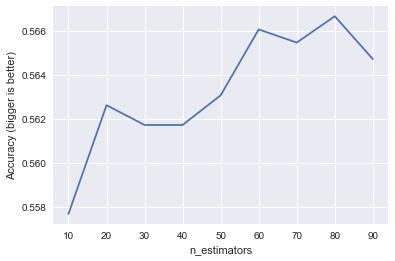

In [81]:
# plot n_estimators (x-axis) versus accuracy (y-axis)
plt.plot(estimator_range, acc_scores_b)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy (bigger is better)')

El número de árboles que maximiza el accuracy es 80 con los datos balanceados

In [116]:
r_forest_b = RandomForestClassifier(n_estimators=80, max_features=3)
r_forest_b.fit(X_train_o, y_train_o)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [117]:
r_forest_b.predict(X_test)

array([1, 1, 0, ..., 0, 1, 0], dtype=int64)

In [118]:
y_pred_rf=r_forest.predict(X_test)


In [119]:
print (" \n Test - Confusion matrix : \n ", metrics.confusion_matrix(y_test, y_pred_rf))
print (" \n Test - classification report : \n ", metrics.classification_report(y_test, y_pred_rf))

 
 Test - Confusion matrix : 
  [[1133   48  120    0    0]
 [ 152  484   63    4    0]
 [ 160   34  393    0    0]
 [   3   13   11   41    0]
 [   2    2    1    1    7]]
 
 Test - classification report : 
               precision    recall  f1-score   support

          0       0.78      0.87      0.82      1301
          1       0.83      0.69      0.75       703
          2       0.67      0.67      0.67       587
          3       0.89      0.60      0.72        68
          4       1.00      0.54      0.70        13

avg / total       0.77      0.77      0.77      2672



Aunque el AUC disminuye un poco, se obtiene mayor precisión en la clasificación de las 4 clases de salida de los animalitos.
Hay un buen balance en el modelo entre precisión y sensitividad.

## 2. KNN

Se usa este clasificador implementando el voto de los k-vecinos más cercanos

## KNN sin datos balanceados

In [210]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Se hace la predicción de las clases

In [211]:
y_pred = neigh.predict(X_test)
y_pred

array([1, 2, 2, ..., 1, 1, 0], dtype=int64)

Las medidas de desempeño son:

In [212]:
print ("Train - Accuracy: \n ", metrics.accuracy_score(y_test, neigh.predict(X_test)))

Train - Accuracy: 
  0.596588358522


Se identifica entre que valores varía el accuracy obtenido si se varían los valores de k vecinos entre 2 y 10:

[0.58476732006583865]
[0.58476732006583865, 0.583270986084094]
[0.58476732006583865, 0.583270986084094, 0.59419422415083045]
[0.58476732006583865, 0.583270986084094, 0.59419422415083045, 0.59658835852162206]
[0.58476732006583865, 0.583270986084094, 0.59419422415083045, 0.59658835852162206, 0.60496782881939248]
[0.58476732006583865, 0.583270986084094, 0.59419422415083045, 0.59658835852162206, 0.60496782881939248, 0.60571599581026481]
[0.58476732006583865, 0.583270986084094, 0.59419422415083045, 0.59658835852162206, 0.60496782881939248, 0.60571599581026481, 0.61140206494089477]
[0.58476732006583865, 0.583270986084094, 0.59419422415083045, 0.59658835852162206, 0.60496782881939248, 0.60571599581026481, 0.61140206494089477, 0.61274876552446511]


Text(0,0.5,'Testing Accuracy')

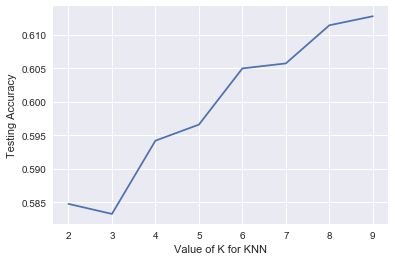

In [213]:
k_range = range(2, 10)
scores = []
for k in k_range:
    kneigh = KNeighborsClassifier(n_neighbors=k)
    kneigh.fit(X_train, y_train)
    y_pred1 = kneigh.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred1))
    print(scores)
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')


De acuerdo con esto, se otiene un mayor accuracy con knn= 9.

Se obtienen los valores del accuracy con knn= 9, aplicando k-folds, así:

In [214]:
res=[]
for i in range(100):
    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3*i)
    kneigh = KNeighborsClassifier(n_neighbors=8)
    kneigh.fit(X_train, y_train)
    y_pred2 = kneigh.predict(X_test)
    res.append(metrics.accuracy_score(y_test, y_pred2))

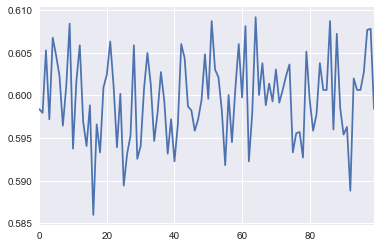

In [215]:
pd.Series(res).plot()

De igual forma si se aplicara cross-validation los valores mínimo y máximo del accuracy serían similares.

In [216]:
from sklearn.cross_validation import cross_val_score
knn = KNeighborsClassifier(n_neighbors=8)

results = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
pd.Series(results).describe()

count    10.000000
mean      0.599671
std       0.006621
min       0.586620
25%       0.595532
50%       0.600500
75%       0.604339
max       0.608088
dtype: float64

Para knn=9, la matriz de confusión es:

In [217]:
print (" \n Test - Confusion matrix : \n ", metrics.confusion_matrix(y_test, y_pred2))
print (" \n Test - classification report : \n ", metrics.classification_report(y_test, y_pred2))

 
 Test - Confusion matrix : 
  [[2138  234  303    8    0]
 [ 690 1444  207   18    0]
 [ 567  205  403   21    0]
 [  91  205   91   14    0]
 [   3   38    2    1    0]]
 
 Test - classification report : 
               precision    recall  f1-score   support

          0       0.61      0.80      0.69      2683
          1       0.68      0.61      0.64      2359
          2       0.40      0.34      0.37      1196
          3       0.23      0.03      0.06       401
          4       0.00      0.00      0.00        44

avg / total       0.57      0.60      0.57      6683



C:\Users\marce\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Las probabilidades obtenidas para cada una de las salidas posibles son:

In [218]:
y_pred2 = kneigh.predict_proba(X_test)
y_pred2

submit = pd.DataFrame()
submit['Return_to_owner']=y_pred2[:,0]
submit['Euthanasia']=y_pred2[:,1]
submit['Adoption']=y_pred2[:,2]
submit['Transfer']=y_pred2[:,3]
submit['Died']=y_pred2[:,4]
submit.head(10)

,Return_to_owner,Euthanasia,Adoption,Transfer,Died
0,0.875,0.125,0.000,0.000,0.0
1,0.375,0.250,0.375,0.000,0.0
2,0.625,0.125,0.250,0.000,0.0
3,0.375,0.125,0.500,0.000,0.0
4,0.250,0.375,0.375,0.000,0.0
5,0.625,0.250,0.125,0.000,0.0
6,0.625,0.375,0.000,0.000,0.0
7,0.125,0.375,0.375,0.125,0.0
8,0.375,0.000,0.625,0.000,0.0
9,1.000,0.000,0.000,0.000,0.0


## KNN con datos balanceados

In [141]:
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
neigh_b = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
neigh_b.fit(X_train_o, y_train_o)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Se hace la predicción de las clases

In [143]:
y_pred_b = neigh.predict(X_test)
y_pred_b

array([0, 0, 2, ..., 2, 2, 0], dtype=int64)

Las medidas de desempeño son:

In [104]:
print ("Train - Accuracy: \n ", metrics.accuracy_score(y_test, neigh.predict(X_test)))

Train - Accuracy: 
  0.666018255275


Se identifica entre que valores varía el accuracy obtenido si se varían los valores de k vecinos entre 2 y 10:

[0.71958701182103846]
[0.71958701182103846, 0.6727517581924285]
[0.71958701182103846, 0.6727517581924285, 0.66871165644171782]
[0.71958701182103846, 0.6727517581924285, 0.66871165644171782, 0.63369744126889127]
[0.71958701182103846, 0.6727517581924285, 0.66871165644171782, 0.63369744126889127, 0.62292383660032924]
[0.71958701182103846, 0.6727517581924285, 0.66871165644171782, 0.63369744126889127, 0.62292383660032924, 0.60107736046685623]
[0.71958701182103846, 0.6727517581924285, 0.66871165644171782, 0.63369744126889127, 0.62292383660032924, 0.60107736046685623, 0.59808469250336671]
[0.71958701182103846, 0.6727517581924285, 0.66871165644171782, 0.63369744126889127, 0.62292383660032924, 0.60107736046685623, 0.59808469250336671, 0.57863235074068531]


Text(0,0.5,'Testing Accuracy')

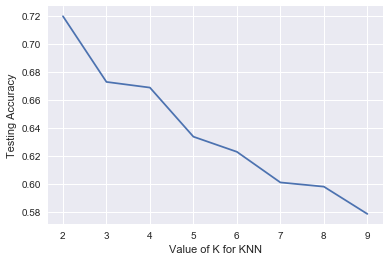

In [105]:
k_range = range(2, 10)
scores = []
for k in k_range:
    kneigh = KNeighborsClassifier(n_neighbors=k)
    kneigh.fit(X_train_o, y_train_o)
    y_pred1_b = kneigh.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, kneigh.predict(X_test)))
    print(scores)
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')


De acuerdo con esto, se otiene un mayor accuracy con knn= 9.

Se obtienen los valores del accuracy con knn= 9, aplicando k-folds, así:

In [106]:
kneigh_b = KNeighborsClassifier(n_neighbors=2)
kneigh_b.fit(X_train_o, y_train_o)
y_pred2_b = kneigh_b.predict(X_test)


Para knn=9, la matriz de confusión es:

In [107]:
print (" \n Test - Confusion matrix : \n ", metrics.confusion_matrix(y_test, y_pred2_b))
print (" \n Test - classification report : \n ", metrics.classification_report(y_test, y_pred2_b))

 
 Test - Confusion matrix : 
  [[2267  123  238   44   11]
 [ 496 1608  127  102   26]
 [ 325  172  655   42    2]
 [  33   69   44  247    8]
 [   2    7    0    3   32]]
 
 Test - classification report : 
               precision    recall  f1-score   support

          0       0.73      0.84      0.78      2683
          1       0.81      0.68      0.74      2359
          2       0.62      0.55      0.58      1196
          3       0.56      0.62      0.59       401
          4       0.41      0.73      0.52        44

avg / total       0.72      0.72      0.72      6683



Con los datos balanceados la precisión mejora, al igual que el f1-score y la clasificación de las clases.

# 3. Gradient Boosting Classifier

## Gradient Boosting Classifier sin datos balanceados


GB construye un modelo aditivo de forma progresiva

Se corre un modelo inicialmente y se encuentra la medida de desempeño accuracy.

In [120]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(loss="deviance",n_estimators=800, learning_rate=1.0)

Se entrena el modelo y se realiza la predicción en la muestra de test

In [121]:
clf.fit(X_train, y_train)
y_predg = clf.predict(X_test)
y_predg

array([1, 1, 2, ..., 2, 1, 0], dtype=int64)

In [122]:
importance=pd.DataFrame({"f":X_train.columns,"import":clf.feature_importances_})
importance.sort_values("import",0,False)

,f,import
1,Age_Months,0.518752
8,Month,0.136846
0,AnimalType,0.130477
7,Year,0.128533
5,color,0.045316
3,Sex,0.014516
6,breed,0.011301
4,Named,0.007852
2,Sterile_Ind,0.006407


Las medidas de desempeño obtenidas son:

In [123]:
print ("Train - Accuracy: \n ", metrics.accuracy_score(y_test,clf.predict(X_test)))
print (" \n Test - Confusion matrix : \n ", metrics.confusion_matrix(y_test, y_predg))
print (" \n Test - classification report : \n ", metrics.classification_report(y_test, y_predg))

Train - Accuracy: 
  0.578592814371
 
 Test - Confusion matrix : 
  [[975  63 261   2   0]
 [263 268 142  29   1]
 [244  41 294   8   0]
 [  8  34  17   9   0]
 [  2   6   2   3   0]]
 
 Test - classification report : 
               precision    recall  f1-score   support

          0       0.65      0.75      0.70      1301
          1       0.65      0.38      0.48       703
          2       0.41      0.50      0.45       587
          3       0.18      0.13      0.15        68
          4       0.00      0.00      0.00        13

avg / total       0.58      0.58      0.57      2672



Se corre nuevamente el modelo, ahora calibrándolo con k-folds y se identifica los valores mínimo y máximo del accuracy

In [112]:
from sklearn.cross_validation import KFold

In [113]:
# Create k-folds se suele usar 10 folds
kf = KFold(X.shape[0], n_folds=10, random_state=0)

results = []

for train_index, test_index in kf:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # train
    clf2 = GradientBoostingClassifier(loss="deviance",n_estimators=800, learning_rate=1.0)
    clf2.fit(X_train, y_train)

    # make predictions for testing set
    y_pred_gb = clf2.predict(X_test)

    # calculate testing accuracy
    results.append(metrics.accuracy_score(y_test, y_pred_gb))

In [98]:
pd.Series(results).describe()

count    10.000000
mean      0.614388
std       0.054601
min       0.511785
25%       0.589859
50%       0.603068
75%       0.665264
max       0.684998
dtype: float64

## Gradient Boosting Classifier con datos balanceados


GB construye un modelo aditivo de forma progresiva

Se corre un modelo inicialmente y se encuentra la medida de desempeño accuracy.

In [126]:
from sklearn.ensemble import GradientBoostingClassifier
clf_b = GradientBoostingClassifier(loss="deviance",n_estimators=800, learning_rate=1.0)

Se entrena el modelo y se realiza la predicción en la muestra de test

In [129]:
clf_b.fit(X_train_o, y_train_o)
y_predg_b = clf_b.predict(X_test)
y_predg_b

array([1, 1, 2, ..., 2, 1, 0], dtype=int64)

Las medidas de desempeño obtenidas son:

In [132]:
print ("Train - Accuracy: \n ", metrics.accuracy_score(y_test,clf_b.predict(X_test)))
print (" \n Test - Confusion matrix : \n ", metrics.confusion_matrix(y_test, y_predg_b))
print (" \n Test - classification report : \n ", metrics.classification_report(y_test, y_predg_b))

Train - Accuracy: 
  0.624251497006
 
 Test - Confusion matrix : 
  [[846  56 391   6   2]
 [153 324 194  29   3]
 [ 90  37 449  11   0]
 [  5  10  13  39   1]
 [  0   2   1   0  10]]
 
 Test - classification report : 
               precision    recall  f1-score   support

          0       0.77      0.65      0.71      1301
          1       0.76      0.46      0.57       703
          2       0.43      0.76      0.55       587
          3       0.46      0.57      0.51        68
          4       0.62      0.77      0.69        13

avg / total       0.68      0.62      0.63      2672



La clasificación de las clases mejora con el balanceo

In [220]:
# Create k-folds se suele usar 10 folds
kf = KFold(X.shape[0], n_folds=10, random_state=0)

results = []

for train_index, test_index in kf:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # train
    clf2 = GradientBoostingClassifier(loss="deviance",n_estimators=100, learning_rate=1.0)
    clf2.fit(X_train_o, y_train_o)

    # make predictions for testing set
    y_pred_gb = clf2.predict(X_test)

    # calculate testing accuracy
    results.append(metrics.accuracy_score(y_test, y_pred_gb))

In [221]:
pd.Series(results).describe()

count    10.000000
mean      0.586740
std       0.036810
min       0.537598
25%       0.557667
50%       0.583614
75%       0.605593
max       0.653199
dtype: float64